# Note sur les cartes cognitives

V2, après nouvelles enquêtes VBO et reprise du thésaurus.

## TODO

- [x] mettre le GAD en catégories/intervalles
  - en `str` c'est OK
- [x] faire l'histo des occ "à la zipf"
- [ ] mixte / le minier / non minier "officiel" ?
  - à étudier
- [ ] créer un premier niveau "nettoyage" du thésaurus
- les mots à problème (polysémie) comme _caillou_
  - une catégorie des `nulls` ? Voir `S.i`
  - accepter un thésaurus à trou

## Notes sur les données

### A l'usage du producteur

Pour faciliter le traitement automatique, assurer la qualité des données

- apostrophe avant date
- espace/majuscules surperflues : respecter l'orthographe, supprimer les articles inutiles, forme fléchies
  - penser à _un dictionnaire_
- colonnes duppliquées (calcul si besoin)
- colonnes de même nom
- colonnes au nom ambigu
- numéro au delà des utilisés
- pas de mise en forme en utilisant des cellules vides

### Notes techniques

- rester tant que possible sur un `DataFrame`,
  - ne pas mixer / casser la srtucture,
  - ou alors, _once and for all_ e.g., pour la liste de réponses,
- assurer la cohérence de la clef : OK (au 2022-05-31)
- gérer les libellés des questions
- la représentation des durées/ages (`ans`)


## Chargement et préparation du jeu de données

On commence par charger le fichier excel et les onglets.


In [41]:
import operator as op

from datetime import date
from pathlib import Path
from collections import Counter
from statistics import fmean

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from catk import CA

# nombre max de mots énoncables = nb colonnes source XLS
MAX_COLS = 20
XLS_SOURCE = Path("../input/BDD_2022-06-21.xlsx")

# Noms des onglets
SHEET_THESAURUS = "Thésaurus"
SHEET_BDD = "BDD"
SHEET_QUESTIONS = "Questions"
SHEET_MOTS = "Mots"

# préfixes des colonnes des mots énoncés
PREFIX_MINE = "Mine"
PREFIX_FUTUR = "Futur"

# noms des cartes
LABEL_MINE = "la mine et le nickel"
LABEL_FUTUR = "la mine dans le futur"

TOP_K_WORDS = 20

cols_mine = [f"{PREFIX_MINE} {i}" for i in range(1, MAX_COLS + 1)]
cols_futur = [f"{PREFIX_FUTUR} {i}" for i in range(1, MAX_COLS + 1)]
cols_censurees = [f"Question {x}" for x in [2, 5.1, 7, 10.1, 11, 14, 14.1]] + ["Commentaire entretien/individu"]


# petit outillage
def clean(s: str) -> str:
    """Nettoyage de chaines"""
    return s.strip().lower()

def pretty_pvals(x):
    """Affichage de courtoisie des niveaux de significativité statistique"""
    if x < 1e-4:
        return "****"
    if x < 1e-3:
        return "***"
    if x < 1e-2:
        return "**"
    if x < 5e-2:
        return "*"
    return ""


Chargement du jeu de données puis division du jeu de données en :

- données personnelles répondant
- cartes la mine
- cartes le futur


In [18]:
df_complete = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_BDD, index_col="Numéro")

# ajout des groupes d'ages quinquennaux/décénaux GAD et GAQ
df_complete["GAD"] = (10 * (df_complete["Question 12"] // 10))
df_complete["GAQ"] = (5 * (df_complete["Question 12"] // 5))

print("Liste des colonnes disponibles")
display(df_complete.columns)


Liste des colonnes disponibles


Index(['Date', 'Commune d’enquête', 'Collecte directe',
       'Commentaire entretien/individu', 'Question 1', 'Question 2',
       'Question 3', 'Question 4', 'Question 5', 'Question 5.1', 'Question 6',
       'Question 7', 'Question 8', 'Question 8.1', 'Question 8.2',
       'Question 9', 'Question 10', 'Question 10.1', 'Question 11',
       'Question 12', 'Question 13', 'Question 14', 'Question 14.1', 'Mine 1',
       'Mine 2', 'Mine 3', 'Mine 4', 'Mine 5', 'Mine 6', 'Mine 7', 'Mine 8',
       'Mine 9', 'Mine 10', 'Mine 11', 'Mine 12', 'Mine 13', 'Mine 14',
       'Mine 15', 'Mine 16', 'Mine 17', 'Mine 18', 'Mine 19', 'Mine 20',
       'Futur 1', 'Futur 2', 'Futur 3', 'Futur 4', 'Futur 5', 'Futur 6',
       'Futur 7', 'Futur 8', 'Futur 9', 'Futur 10', 'Futur 11', 'Futur 12',
       'Futur 13', 'Futur 14', 'Futur 15', 'Futur 16', 'Futur 17', 'Futur 18',
       'Futur 19', 'Futur 20', 'GAD', 'GAQ'],
      dtype='object')

In [19]:
cols_resp = [c for c in df_complete.columns if c not in cols_mine + cols_futur + cols_censurees]

df_resp = df_complete[cols_resp]
df_resp.name = "Données personnelles"
df_mine = df_complete[cols_mine].astype("string")
df_mine.name = f"Cartes cognitives '{LABEL_MINE}'"
df_futur = df_complete[cols_futur].astype("string")
df_futur.name = f"Cartes cognitives '{LABEL_FUTUR}'"

print(f"Nombre de répondants {len(df_complete)}")
print(f"Colonnes '{LABEL_MINE}' présentes {set(cols_mine) <= set(df_complete.columns)}")
print(f"Colonnes '{LABEL_FUTUR}' présentes {set(cols_futur) <= set(df_complete.columns)}")


Nombre de répondants 508
Colonnes 'la mine et le nickel' présentes True
Colonnes 'la mine dans le futur' présentes True


### Informations personnelles des répondants

In [27]:
df_questions = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_QUESTIONS, parse_dates=False).astype(
    {"Question": "string", "Libellé": "string"}
)

print(f"Toutes les questions posées bien présentes chez les répondants {set(df_questions['Question']) <= (set(df_resp.columns) | set(cols_censurees))}")
display(df_questions)

# mise sous forme de dictionnaire pour remplacer les questions par leurs labels dans les résultats/légendes
questions_labels = df_questions.set_index("Question").to_dict()["Libellé"]  # orient="series"


Toutes les questions posées bien présentes chez les répondants True


,Question,Libellé
0,Question 1,Travaillez-vous ou avez travaillez pour l’indu...
1,Question 2,"Si oui, quel(s) étai(en)t votre/vos poste(s) ?"
2,Question 3,Depuis combien de temps travaillez-vous ou pen...
3,Question 4,Un membre de votre famille travaille t’il ou a...
4,Question 5,Avez-vous toujours vécu en Nouvelle-Calédonie ?
5,Question 5.1,"Si non, d’où venez-vous ?"
6,Question 6,"Si non, depuis combien de temps vivez-vous en ..."
7,Question 7,"Si non, pourquoi vous êtes vous installé(e) en..."
8,Question 8,Où habitez-vous ? (Le plus précis possible san...
9,Question 8.1,Commune de résidence.


In [28]:
# display(df_resp.info())
display(df_resp)


,Date,Commune d’enquête,Collecte directe,Question 1,Question 3,Question 4,Question 5,Question 6,Question 8,Question 8.1,Question 8.2,Question 9,Question 10,Question 12,Question 13,GAD,GAQ
Numéro,,,,,,,,,,,,,,,,,
1,2021-06-09,Thio,Oui,Non,NaN,Oui,Oui,NaN,Thio - St Philippo 2,Thio,Minière,59.0,Oui,59.0,Homme,50.0,55.0
2,2021-06-09,Thio,Oui,Non,NaN,Non,Non,3.0,Thio,Thio,Minière,3.0,Non,63.0,Homme,60.0,60.0
3,2021-06-09,Thio,Oui,Non,NaN,Oui,Oui,NaN,Thio,Thio,Minière,35.0,Non,35.0,Femme,30.0,35.0
4,2021-06-09,Thio,Oui,Oui,15 ans,Oui,Oui,NaN,Thio - Mission,Thio,Minière,52.0,Non,52.0,Homme,50.0,50.0
5,2021-06-10,Thio,Oui,Non,NaN,Oui,Oui,NaN,Thio - St Philippo 1,Thio,Minière,50.0,Oui,69.0,Femme,60.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2022-03-10,Hienghène,Oui,Non,NaN,Non,Oui,NaN,Village,Hienghène,Non minière,NaN,Non,14.0,Femme,10.0,10.0
505,2022-03-10,Hienghène,Oui,Non,NaN,Oui,Oui,NaN,Caavatch,Hienghène,Non minière,NaN,Non,13.0,Femme,10.0,10.0
506,2022-03-10,Hienghène,Oui,Non,NaN,Oui,Oui,NaN,Panié,Hienghène,Non minière,NaN,Oui,13.0,Homme,10.0,10.0


Cartes cognitives 'la mine'

In [29]:
display(df_mine)


,Mine 1,Mine 2,Mine 3,Mine 4,Mine 5,Mine 6,Mine 7,Mine 8,Mine 9,Mine 10,Mine 11,Mine 12,Mine 13,Mine 14,Mine 15,Mine 16,Mine 17,Mine 18,Mine 19,Mine 20
Numéro,,,,,,,,,,,,,,,,,,,,
1,Pollution,Inondation,Boom,Travail,Retombée,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Richesse,Malédiction,Travail,Destruction,Histoire,Frein,Blocage,Coutumier,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Travail,Pollution,Plainte,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Argent,Pollution,Nickel,Production,Nature,Réparation,Mer,Inégalité,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,Extraction,Montagne,Pollution,Mineur,Train,Diversité,Évolution,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,Caillou,Camion,Fer,Ramassage,Faire fondre le nickel,Transport,Bâteau,Construire des Objet,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
505,Granite,Usine,Richesse,Epuisable,Pétrole,Cailloux,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
506,Exploitation,Richesse,Conflit,Détruit le lagon,Pollution,Argent,Vol d'argent,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Cartes cognitives 'la mine futur'

In [30]:
display(df_futur)


,Futur 1,Futur 2,Futur 3,Futur 4,Futur 5,Futur 6,Futur 7,Futur 8,Futur 9,Futur 10,Futur 11,Futur 12,Futur 13,Futur 14,Futur 15,Futur 16,Futur 17,Futur 18,Futur 19,Futur 20
Numéro,,,,,,,,,,,,,,,,,,,,
1,Fermeture,Usine de Doniambo,Travail,Creusage,Droit,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Impossible,Indispensable,Gestion,Enjeu,Concurrence,Rationnalisation,Entente,Difficile,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Rien,Après-nickel,Pollution,Activité,Épuisement,Rebondissement,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Montagne,Poisson,Dépotoir,Répartition,Rendement,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,Extraction,Tradition,Repère,Action,Adaptation,Pauvre,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,Il aura plus,Pollution,Usine abandonnée,Trop exploité,Camion,Outils de travail,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
505,Epuisé,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
506,Exploitation,Destruction nature,Conflit,Destruction du lagon,Pollution,Terrain trop exploité,Destruction de notre pays,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Vérifications et indicateurs globaux

Création des dictionnaires de réponses sur les deux enquêtes avec quelques statistiques

In [31]:
# fonction outil pour transformer le dataframe en dictionnaire des mots énoncés
def get_cogmaps(df, cols):
    return {idx: [clean(val) for val in vals.dropna().tolist()] for idx, vals in df[cols].astype("string").iterrows()}


# les deux dictionnaire principaux
dict_mine = get_cogmaps(df_complete, cols_mine)
dict_futur = get_cogmaps(df_complete, cols_futur)

for dic, lbl in ((dict_mine, LABEL_MINE), (dict_futur, LABEL_FUTUR)):
    print(f"Cartes '{lbl}'")
    print(f"\tplus longue cartes {max(len(val) for val in dic.values())}")
    print(f"\tlongueur moyenne des cartes {fmean(len(val) for val in dic.values()):.2f}")
    print(f"\tnombre total de mots énoncés {sum(len(val) for val in dic.values())}")
    print(f"\tnombre de mots énoncés différents {len(set(v for val in dic.values() for v in val))}")
    print()


Cartes 'la mine et le nickel'
	plus longue cartes 20
	longueur moyenne des cartes 7.61
	nombre total de mots énoncés 3865
	nombre de mots énoncés différents 922

Cartes 'la mine dans le futur'
	plus longue cartes 18
	longueur moyenne des cartes 4.68
	nombre total de mots énoncés 2376
	nombre de mots énoncés différents 912



Les mots les plus cités

In [32]:
for dic, lbl in ((dict_mine, LABEL_MINE), (dict_futur, LABEL_FUTUR)):
    words = Counter(w for l in dic.values() for w in l)
    print(f"Cartes '{lbl}' : {len(words)} mots. Top {TOP_K_WORDS}, toutes positions confondues :")
    display(words.most_common(TOP_K_WORDS))


Cartes 'la mine et le nickel' : 922 mots. Top 20, toutes positions confondues :


[
    ('nickel', 189),
    ('pollution', 182),
    ('économie', 112),
    ('camion', 104),
    ('travail', 100),
    ('environnement', 100),
    ('emploi', 97),
    ('usine', 89),
    ('argent', 76),
    ('richesse', 74),
    ('montagne', 74),
    ('terre', 73),
    ('exploitation', 65),
    ('minerai', 65),
    ('destruction', 60),
    ('ressource', 56),
    ('sln', 54),
    ('conflit', 50),
    ('déforestation', 42),
    ('caillou', 38)
]

Cartes 'la mine dans le futur' : 912 mots. Top 20, toutes positions confondues :


[
    ('pollution', 122),
    ('économie', 54),
    ('environnement', 50),
    ('emploi', 49),
    ('ressource', 43),
    ('épuisement', 32),
    ('destruction', 32),
    ('conflit', 28),
    ('richesse', 26),
    ('technologie', 24),
    ('développement', 24),
    ('montagne', 22),
    ('travail', 21),
    ('impact', 21),
    ('reboisement', 20),
    ('disparition', 20),
    ('argent', 18),
    ('fin', 18),
    ('exploitation', 18),
    ('déforestation', 17)
]

Longueur des cartes et leur histogramme


Répartitions des longueurs des cartes


<Figure size 432x288 with 1 Axes>

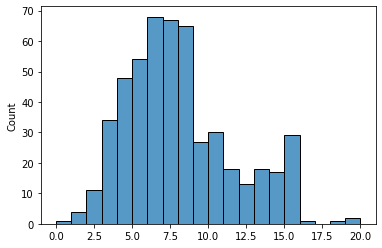

<Figure size 432x288 with 1 Axes>

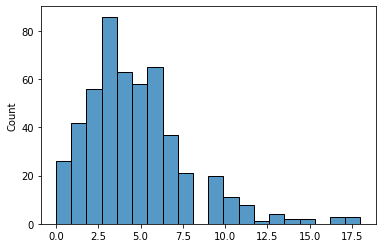

In [33]:
def get_n_words(dic, n: int):
    """Mot de la position n"""
    return [vals[n] for vals in dic.values() if n < len(vals)]


print("Répartitions des longueurs des cartes")
sns.histplot([len(vals) for vals in dict_mine.values()], bins=20)
plt.show()
sns.histplot([len(vals) for vals in dict_futur.values()], bins=20)
plt.show()


## Quelques indicateurs sur les profils des répondants


Histogramme des ages des répondants


<AxesSubplot:xlabel='Question 12', ylabel='Count'>

<Figure size 432x288 with 1 Axes>

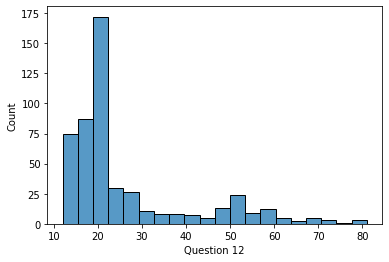

In [39]:
print("Histogramme des ages des répondants")
sns.histplot(df_resp["Question 12"], bins=20)

On va calculer les effectifs du nombre de personnes pour les valeurs prises par quelques questions.


In [35]:
# fonction outil pour les calculs d'effectifs
def groupby(questions):
    """Prend une liste de questions, fait le group by et renomme les colonnes"""
    return df_complete.value_counts(subset=questions, sort=False).rename_axis(
        [questions_labels.get(q, q) for q in questions]
    )


display(groupby(["Question 1", "Question 4"]))
display(groupby(["Question 8.1"]).sort_values())
display(groupby(["GAD", "Question 8.2"]))


Travaillez-vous ou avez travaillez pour l’industrie minière ou métallurgique ?  Un membre de votre famille travaille t’il ou a t’il travaillé pour cette industrie ?
Non                                                                             Non                                                                                     136
                                                                                Oui                                                                                     300
Oui                                                                             Non                                                                                      12
                                                                                Oui                                                                                      55
dtype: int64

Commune de résidence.
Île des Pins               1
Koumac                     1
La Foa                     1
Paris                      1
Moindou                    1
Voh                        2
Kaala-Gomen                2
Ponérihouen                2
Pouébo                     3
Pouembout                  3
Poya                       4
Poindimié                  4
Ouégoa                     4
Boulouparis                4
Houaïlou                   4
Maré                       6
Koné                       7
Bourail                    7
Lifou                     10
Touho                     11
Thio                      16
Yaté                      30
Païta                     37
Dumbéa                    61
Mont-Dore                 80
Hienghène                 96
Nouméa                   109
dtype: int64

GAD   Distinction communes minières ; non-minière et mixte (Nouméa)
10.0  Minière                                                           64
      Mixte                                                             46
      Non minière                                                      121
20.0  Minière                                                           29
      Mixte                                                             54
      Non minière                                                       75
30.0  Minière                                                           13
      Mixte                                                              3
      Non minière                                                       11
40.0  Minière                                                           14
      Mixte                                                              4
      Non minière                                                        7
50.0  Minière                                                           18
      Mixte                                                              7
      Non minière                                                       16
60.0  Minière                                                            7
      Non minière                                                        8
70.0  Minière                                                            1
      Mixte                                                              2
      Non minière                                                        3
80.0  Minière                                                            2
dtype: int64

#### Répartition GAD/commune

In [38]:
s = pd.DataFrame(groupby(["GAD", "Question 8.1"])).reset_index().rename(columns={0: "Nb"})  # .to_csv("test.csv")
s.pivot(index="Commune de résidence.", columns="GAD").fillna(0).astype(int)


Nb 
 
 
 GAD 
 10.0 
 20.0 
 30.0 
 40.0 
 50.0 
 60.0 
 70.0 
 80.0 
 
 
 Commune de résidence. 
 
 
 
 
 
 
 
 
 
 
 
 
 Boulouparis 
 3 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Bourail 
 2 
 3 
 0 
 1 
 1 
 0 
 0 
 0 
 
 
 Dumbéa 
 23 
 28 
 2 
 2 
 3 
 2 
 0 
 0 
 
 
 Hienghène 
 65 
 8 
 6 
 3 
 6 
 5 
 2 
 0 
 
 
 Houaïlou 
 0 
 1 
 3 
 0 
 0 
 0 
 0 
 0 
 
 
 Kaala-Gomen 
 0 
 2 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Koné 
 3 
 2 
 1 
 1 
 0 
 0 
 0 
 0 
 
 
 Koumac 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 La Foa 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Lifou 
 3 
 6 
 0 
 1 
 0 
 0 
 0 
 0 
 
 
 Maré 
 1 
 5 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Moindou 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Mont-Dore 
 50 
 18 
 1 
 5 
 6 
 0 
 0 
 0 
 
 
 Nouméa 
 43 
 51 
 3 
 3 
 7 
 0 
 2 
 0 
 
 
 Ouégoa 
 0 
 4 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Paris 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Païta 
 13 
 14 
 3 
 0 
 5 
 1 
 1 
 0 
 
 
 Poindimié 
 1 
 3 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Ponérihouen 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Pouembout 
 0 
 1 
 2 
 0 
 0 
 0 
 0 
 0 
 
 
 Pouébo 
 0 
 3 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Poya 
 3 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 
 
 Thio 
 1 
 1 
 1 
 6 
 4 
 3 
 0 
 0 
 
 
 Touho 
 11 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Voh 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 Yaté 
 4 
 4 
 5 
 2 
 8 
 4 
 1 
 2 
 
 
 Île des Pins 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0

#### Répartition commune/type commune

In [37]:
s = pd.DataFrame(groupby(["Question 8.1", "Question 8.2"])).reset_index().rename(columns={0: "Nb"})  # .to_csv("test.csv")
s.pivot(index="Commune de résidence.", columns="Distinction communes minières ; non-minière et mixte (Nouméa)").fillna(0).astype(int)


Nb 
 
 
 Distinction communes minières ; non-minière et mixte (Nouméa) 
 Minière 
 Mixte 
 Non minière 
 
 
 Commune de résidence. 
 
 
 
 
 
 
 
 Boulouparis 
 4 
 0 
 0 
 
 
 Bourail 
 0 
 0 
 7 
 
 
 Dumbéa 
 0 
 0 
 61 
 
 
 Hienghène 
 0 
 1 
 95 
 
 
 Houaïlou 
 4 
 0 
 0 
 
 
 Kaala-Gomen 
 2 
 0 
 0 
 
 
 Koné 
 1 
 6 
 0 
 
 
 Koumac 
 1 
 0 
 0 
 
 
 La Foa 
 0 
 0 
 1 
 
 
 Lifou 
 0 
 0 
 10 
 
 
 Maré 
 0 
 0 
 6 
 
 
 Moindou 
 0 
 0 
 1 
 
 
 Mont-Dore 
 80 
 0 
 0 
 
 
 Nouméa 
 0 
 109 
 0 
 
 
 Ouégoa 
 0 
 0 
 4 
 
 
 Païta 
 0 
 0 
 37 
 
 
 Poindimié 
 0 
 0 
 4 
 
 
 Ponérihouen 
 0 
 0 
 2 
 
 
 Pouembout 
 3 
 0 
 0 
 
 
 Pouébo 
 0 
 0 
 3 
 
 
 Poya 
 4 
 0 
 0 
 
 
 Thio 
 16 
 0 
 0 
 
 
 Touho 
 1 
 0 
 10 
 
 
 Voh 
 2 
 0 
 0 
 
 
 Yaté 
 30 
 0 
 0 
 
 
 Île des Pins 
 0 
 0 
 1

## Mots les plus communs pour la carte "la mine"

On va segmenter les données en _populations_ (e.g., "moins de 26 ans", "mineur", etc.) selon les attributs et générer un tableau avec :

- en ligne tous les mots énoncés dans les cartes "la mine"
- en colonne, les populations, avec pour chacune :
  - le nombre de fois où le mot a été énoncé par les membres de cette population
  - le nombre de fois "théorique" où le mot serait annoncé si il y avait indépendance des énonciations entre les populations
  - le % de fois où un membre de la population a énoncé le mot
- pour chaque groupe, on calcule ensuite un test du $\chi^2$ pour évaluer l'écart à l'indépendance


In [48]:
THRESHOLD_MIN_ENONCIATIONS = 20
LABEL_TOTAL = "Total"
ALL_SYMB = "*"
CLEF_TOTAL = (ALL_SYMB, ALL_SYMB, LABEL_TOTAL)


# comptage du nombre d'occurence total, en oubliant les répondants
all_words_mine = Counter(w for l in dict_mine.values() for w in l)
all_words_futur = Counter(w for l in dict_futur.values() for w in l)

# transformation en DF
df_enonces = pd.DataFrame(index=list(all_words_mine.keys()))
df_enonces[CLEF_TOTAL] = all_words_mine.values()

# filtrage au dessus du seuil et tri
df_enonces = df_enonces[df_enonces[CLEF_TOTAL] >= THRESHOLD_MIN_ENONCIATIONS]
df_enonces.sort_values(CLEF_TOTAL, key=op.neg, inplace=True)
display(df_enonces)


,"(*, *, Total)"
nickel,189
pollution,182
économie,112
camion,104
travail,100
environnement,100
emploi,97
usine,89
argent,76
richesse,74


## Tableau de comparaison des mots énoncés par profil du répondant

**NB** Ici un gros poitn méthodologique : on va faire un test d'indépendance statistique $\chi^2$ sur les mots énoncés les plus fréquents afin de déterminer si leurs énonciations sont indépendantes ou pas des profils des répondants.

In [49]:
def add_population(df_population, filtres, name):
    """Ajout de colonnes au df de synthèse des profils sur une population segmentée"""
    observed = []
    expected = []
    chi2 = stats.chi2(len(filtres) - 1)
    for filtre, val in filtres:
        cg = get_cogmaps(df_mine[filtre], cols_mine)
        c = Counter(w for l in cg.values() for w in l)
        print(f"Ajout de la colonne '{name}, {val}', {len(cg)} répondants, {c.total()} énonciations")

        key = (name, val, "Nb.")
        df_population[key] = pd.Series(c)
        df_population[key].fillna(0, inplace=True)
        df_population[key] = df_population[key].astype(int)


        # ici en % ** des répondants**
        df_population[(name, val, "Nb. th.")] = round(df_population[CLEF_TOTAL] * len(cg) / len(df_mine), 2)
        exp = df_population[CLEF_TOTAL].to_numpy() * len(cg) / len(df_mine)

        observed.append(df_population[key].to_numpy().reshape(-1, 1))
        expected.append(exp.reshape(-1, 1))

    obs, exp = np.concatenate(observed, axis=1), np.concatenate(expected, axis=1)
    chis = np.sum((obs - exp) ** 2 / exp, axis=1)
    p_vals = chi2.sf(chis)
    df_population[(name, "Chi²", "Significatif")] = [pretty_pvals(v) for v in p_vals]


def generate_all_filters(col):
    values = df_resp[col].dropna().unique()
    return [(df_resp[col] == value, value) for value in values]


moins_de_26_ans = df_resp["Question 12"] < 26
add_population(df_enonces, [(moins_de_26_ans, "Oui"), (~moins_de_26_ans, "Non")], "Age < 26")
add_population(df_enonces, generate_all_filters("Question 13"), "Genre")
add_population(df_enonces, generate_all_filters("Question 1"), "Travaille dans la mine")
add_population(df_enonces, generate_all_filters("Question 4"), "Famille dans la mine")
add_population(df_enonces, generate_all_filters("Question 5"), "Toujours vécu en NC")
# pour ça, plutôt faire une AFC
add_population(df_enonces, generate_all_filters("Question 8.2"), "Commune minière")


# nettoyage final
df_enonces.fillna(0.0, inplace=True)
df_enonces.columns = pd.MultiIndex.from_tuples(df_enonces.columns)
df_enonces.columns.set_names(["Variable", "Catégorie", "Statistique"], inplace=True)
display(df_enonces)



Ajout de la colonne 'Age < 26, Oui', 364 répondants, 2837 énonciations
Ajout de la colonne 'Age < 26, Non', 144 répondants, 1028 énonciations
Ajout de la colonne 'Genre, Homme', 226 répondants, 1745 énonciations
Ajout de la colonne 'Genre, Femme', 278 répondants, 2090 énonciations
Ajout de la colonne 'Genre, Autre', 4 répondants, 30 énonciations
Ajout de la colonne 'Travaille dans la mine, Non', 438 répondants, 3328 énonciations
Ajout de la colonne 'Travaille dans la mine, Oui', 68 répondants, 520 énonciations
Ajout de la colonne 'Famille dans la mine, Oui', 355 répondants, 2765 énonciations
Ajout de la colonne 'Famille dans la mine, Non', 148 répondants, 1068 énonciations
Ajout de la colonne 'Toujours vécu en NC, Oui', 400 répondants, 2998 énonciations
Ajout de la colonne 'Toujours vécu en NC, Non', 105 répondants, 846 énonciations
Ajout de la colonne 'Commune minière, Minière', 148 répondants, 1116 énonciations
Ajout de la colonne 'Commune minière, Mixte', 116 répondants, 990 énoncia

Variable 
 * 
 Age < 26 
 Genre 
 ... 
 Toujours vécu en NC 
 Commune minière 
 
 
 Catégorie 
 * 
 Oui 
 Non 
 Chi² 
 Homme 
 Femme 
 ... 
 Non 
 Chi² 
 Minière 
 Mixte 
 Non minière 
 Chi² 
 
 
 Statistique 
 Total 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Significatif 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 ... 
 Nb. 
 Nb. th. 
 Significatif 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Nb. 
 Nb. th. 
 Significatif 
 
 
 
 
 nickel 
 189 
 151 
 135.43 
 38 
 53.57 
 * 
 81 
 84.08 
 107 
 103.43 
 ... 
 40 
 39.06 
 
 53 
 55.06 
 67 
 43.16 
 68 
 90.41 
 **** 
 
 
 pollution 
 182 
 118 
 130.41 
 64 
 51.59 
 * 
 91 
 80.97 
 88 
 99.60 
 ... 
 41 
 37.62 
 
 61 
 53.02 
 41 
 41.56 
 80 
 87.06 
 
 
 
 économie 
 112 
 78 
 80.25 
 34 
 31.75 
 
 49 
 49.83 
 61 
 61.29 
 ... 
 26 
 23.15 
 
 39 
 32.63 
 42 
 25.57 
 31 
 53.57 
 **** 
 
 
 camion 
 104 
 92 
 74.52 
 12 
 29.48 
 *** 
 41 
 46.27 
 61 
 56.91 
 ... 
 6 
 21.50 
 *** 
 22 
 30.30 
 21 
 23.75 
 61 
 49.75 
 
 
 
 travail 
 100 
 74 
 71.65 
 26 
 28.35 
 
 41 
 44.49 
 57 
 54.72 
 ... 
 30 
 20.67 
 * 
 28 
 29.13 
 23 
 22.83 
 49 
 47.83 
 
 
 
 environnement 
 100 
 60 
 71.65 
 40 
 28.35 
 ** 
 47 
 44.49 
 53 
 54.72 
 ... 
 25 
 20.67 
 
 30 
 29.13 
 34 
 22.83 
 36 
 47.83 
 * 
 
 
 emploi 
 97 
 68 
 69.50 
 29 
 27.50 
 
 50 
 43.15 
 45 
 53.08 
 ... 
 23 
 20.05 
 
 29 
 28.26 
 31 
 22.15 
 37 
 46.40 
 
 
 
 usine 
 89 
 83 
 63.77 
 6 
 25.23 
 **** 
 33 
 39.59 
 56 
 48.70 
 ... 
 15 
 18.40 
 
 18 
 25.93 
 21 
 20.32 
 50 
 42.57 
 
 
 
 argent 
 76 
 44 
 54.46 
 32 
 21.54 
 ** 
 38 
 33.81 
 38 
 41.59 
 ... 
 15 
 15.71 
 
 29 
 22.14 
 13 
 17.35 
 33 
 36.35 
 
 
 
 richesse 
 74 
 48 
 53.02 
 26 
 20.98 
 
 33 
 32.92 
 40 
 40.50 
 ... 
 21 
 15.30 
 
 16 
 21.56 
 22 
 16.90 
 36 
 35.40 
 
 
 
 montagne 
 74 
 58 
 53.02 
 16 
 20.98 
 
 25 
 32.92 
 49 
 40.50 
 ... 
 8 
 15.30 
 * 
 19 
 21.56 
 14 
 16.90 
 41 
 35.40 
 
 
 
 terre 
 73 
 60 
 52.31 
 13 
 20.69 
 * 
 34 
 32.48 
 39 
 39.95 
 ... 
 10 
 15.09 
 
 13 
 21.27 
 9 
 16.67 
 51 
 34.92 
 *** 
 
 
 minerai 
 65 
 59 
 46.57 
 6 
 18.43 
 *** 
 23 
 28.92 
 41 
 35.57 
 ... 
 9 
 13.44 
 
 25 
 18.94 
 15 
 14.84 
 25 
 31.09 
 
 
 
 exploitation 
 65 
 59 
 46.57 
 6 
 18.43 
 *** 
 32 
 28.92 
 32 
 35.57 
 ... 
 16 
 13.44 
 
 23 
 18.94 
 14 
 14.84 
 28 
 31.09 
 
 
 
 destruction 
 60 
 33 
 42.99 
 27 
 17.01 
 ** 
 24 
 26.69 
 35 
 32.83 
 ... 
 17 
 12.40 
 
 21 
 17.48 
 11 
 13.70 
 28 
 28.70 
 
 
 
 ressource 
 56 
 48 
 40.13 
 8 
 15.87 
 * 
 25 
 24.91 
 30 
 30.65 
 ... 
 11 
 11.57 
 
 16 
 16.31 
 21 
 12.79 
 19 
 26.79 
 * 
 
 
 sln 
 54 
 46 
 38.69 
 8 
 15.31 
 * 
 21 
 24.02 
 33 
 29.55 
 ... 
 13 
 11.16 
 
 16 
 15.73 
 15 
 12.33 
 23 
 25.83 
 
 
 
 conflit 
 50 
 40 
 35.83 
 10 
 14.17 
 
 20 
 22.24 
 28 
 27.36 
 ... 
 13 
 10.33 
 
 21 
 14.57 
 9 
 11.42 
 20 
 23.92 
 
 
 
 déforestation 
 42 
 35 
 30.09 
 7 
 11.91 
 
 23 
 18.69 
 19 
 22.98 
 ... 
 8 
 8.68 
 
 11 
 12.24 
 13 
 9.59 
 18 
 20.09 
 
 
 
 caillou 
 38 
 36 
 27.23 
 2 
 10.77 
 ** 
 10 
 16.91 
 28 
 20.80 
 ... 
 4 
 7.85 
 
 10 
 11.07 
 10 
 8.68 
 18 
 18.18 
 
 
 
 exportation 
 31 
 29 
 22.21 
 2 
 8.79 
 ** 
 11 
 13.79 
 19 
 16.96 
 ... 
 5 
 6.41 
 
 10 
 9.03 
 10 
 7.08 
 11 
 14.83 
 
 
 
 développement 
 30 
 21 
 21.50 
 9 
 8.50 
 
 18 
 13.35 
 11 
 16.42 
 ... 
 11 
 6.20 
 * 
 10 
 8.74 
 8 
 6.85 
 12 
 14.35 
 
 
 
 terre rouge 
 30 
 25 
 21.50 
 5 
 8.50 
 
 10 
 13.35 
 20 
 16.42 
 ... 
 5 
 6.20 
 
 12 
 8.74 
 6 
 6.85 
 12 
 14.35 
 
 
 
 nature 
 28 
 10 
 20.06 
 18 
 7.94 
 **** 
 11 
 12.46 
 16 
 15.32 
 ... 
 5 
 5.79 
 
 9 
 8.16 
 2 
 6.39 
 17 
 13.39 
 
 
 
 engin 
 26 
 16 
 18.63 
 10 
 7.37 
 
 6 
 11.57 
 20 
 14.23 
 ... 
 4 
 5.37 
 
 9 
 7.57 
 6 
 5.94 
 11 
 12.44 
 
 
 
 métal 
 24 
 23 
 17.20 
 1 
 6.80 
 ** 
 12 
 10.68 
 11 
 13.13 
 ... 
 3 
 4.96 
 
 4 
 6.99 
 2 
 5.48 
 18 
 11.48 
 * 
 
 
 extraction 
 22 
 18 
 15.7

On va enregister le fichier

In [15]:
today = date.today().strftime("%Y-%m-%d")
output = Path("../output_v2")
output.mkdir(parents=True, exist_ok=True)
df_enonces.to_excel(output / f"analyse_par_population-{today}.xlsx")


### Éléments d'analyse

**TODO**

## Complétude du thésaurus


In [16]:
df_thesaurus = pd.read_excel(FILENAME, sheet_name="Thésaurus_2")
concepts = df_thesaurus.columns.to_list()


thesaurus = {
    clean(key): [clean(val) for val in vals if val is not np.nan]
    for key, vals in df_thesaurus.to_dict(orient="list").items()
}

print(f"Nombre de concepts dans le thésaurus {len(thesaurus)}")
print(f"Nombre de mots classés dans le thésaurus {sum(len(vals) for vals in thesaurus.values())}")


Nombre de concepts dans le thésaurus 38
Nombre de mots classés dans le thésaurus 1087


In [17]:
all_words_thesaurus = [val for vals in thesaurus.values() for val in vals]
print(f"Nombre de mots du thésaurus = {[len(vals) for vals in thesaurus.values()]}")
print(f"Nombre total de mots du thésaurus = {len(all_words_thesaurus)}")
print(f"Nombre de mots du thésaurus sans doublons = {len(set(all_words_thesaurus))}")
print(f"Doublons dans le thésaurus : {len(all_words_thesaurus) != len(set(all_words_thesaurus))}")


Nombre de mots du thésaurus = [40, 57, 10, 29, 38, 23, 66, 11, 18, 50, 25, 51, 147, 89, 20, 2, 6, 43, 38, 8, 87, 13, 30, 43, 1, 9, 12, 10, 7, 8, 9, 3, 18, 9, 7, 7, 20, 23]
Nombre total de mots du thésaurus = 1087
Nombre de mots du thésaurus sans doublons = 1070
Doublons dans le thésaurus : True


In [18]:
occ_mutiples = {
    mot: [concept for concept, vals in thesaurus.items() if mot in vals]
    for mot, occ in Counter(all_words_thesaurus).items()
    if occ > 1
}

print(f"{len(occ_mutiples)} mots avec occurrences multiples dans le thésaurus, pour chaque, la liste des concepts où il apparait")
display(occ_mutiples)


16 mots avec occurrences multiples dans le thésaurus, pour chaque, la liste des concepts où il apparait


{
    'corruption': ['avis péjoratifs et interactions négatives'],
    'lagon': ['ressources marines'],
    'honneur': ['valeurs sociales et interactions positives'],
    'liens': ['valeurs sociales et interactions positives', 'territoire'],
    'caillou': ['territoire', 'ressource nickel'],
    'foncier': ['territoire'],
    'prospérité': ['territoire', 'avantage-bénéfice économique et financier'],
    'intégration': ['territoire', 'métiers dans le secteur du nickel'],
    'epuisement': ['epuisement des ressources naturelles', 'ressource nickel'],
    'travail': [
        'avantage-bénéfice économique et financier',
        'secteur extractif et  industriel du nickel',
        'ressource nickel'
    ],
    'voiture': [
        'avantage-bénéfice économique et financier',
        "pouvoir d'achat et évolution des conditions matérielles de vie"
    ],
    'rivière rouge': [
        'paysage minier',
        'dégradation-impact environnemental négatif'
    ],
    'métier à risque': ['secteur extractif et  industriel du nickel'],
    'fabrication': [
        'secteur extractif et  industriel du nickel',
        'vocabulaire technique lié à la métallurgie'
    ],
    'métal rare': ['ressource nickel'],
    'problème': ['termes négatifs']
}

In [19]:
mots_mine_sans_concept = set(all_words_mine) - set(all_words_thesaurus)
print(f"Il y a {len(mots_mine_sans_concept)} mots des cartes '{LABEL_MINE}' qui ne sont pas dans le thésaurus.")
print("On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) ")
mots_mine_sans_concept_pos = {
    mot: [num for num, mots in dict_mine.items() if mot in mots] for mot in mots_mine_sans_concept
}
display(mots_mine_sans_concept_pos)


Il y a 242 mots des cartes 'la mine et le nickel' qui ne sont pas dans le thésaurus.
On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) 


{
    'extrait du sol': [491],
    'puissance': [51],
    'métalique': [437],
    'emploi non-qualifié': [150],
    'veste': [495],
    'plus de présence humaine': [490],
    'marché': [157, 189, 409],
    'travailleur de nuit': [464],
    'beaucoup de richesse': [490],
    'lumière': [470],
    'énergie fossile': [254, 290],
    "comme de l'or": [452],
    'dégradation du pays': [490],
    'promesse d’embauche': [248],
    'bloc': [123],
    'poisson': [51],
    'épuisant': [199],
    "beaucoup d'exploitation": [490],
    'poumon': [196],
    'inégalité': [4, 302],
    'métal': [
        92,
        131,
        177,
        238,
        261,
        302,
        325,
        326,
        344,
        383,
        437,
        446,
        454,
        460,
        461,
        463,
        464,
        475,
        479,
        485,
        488,
        490,
        495,
        498,
        500
    ],
    'activité économique': [375],
    'fer rubané': [152],
    'solidarité': [439],
    'revenu': [7, 28, 34, 46, 80, 132, 160, 186, 231, 242, 256, 395],
    'respecter': [475],
    'échelle': [354],
    'opportunité': [14, 325],
    'détruire des choses': [472],
    'eléctricité': [470],
    'moins de terre': [490],
    'métallurgique': [438],
    'employés': [474, 508],
    'ventes': [502],
    'fatigue': [469],
    'alarme': [482],
    'entrepôt': [464],
    'vital': [62],
    'articulé': [474],
    'mines partout': [450],
    'délicatesse': [86],
    'engins': [434, 463, 464, 487, 496, 508],
    'eboulement': [482],
    'europe': [490],
    'engin d’extraction': [308],
    'lave': [445, 448, 453, 463],
    'car': [436],
    'gueule noire': [319],
    'bénéfique': [309],
    'ressource épuisable': [109, 249],
    'usines': [454, 455, 479, 484, 508],
    'évolution': [5, 17, 27, 248, 333],
    'barrage de yaté': [493],
    'construire des objets': [504],
    'forêt détruite': [468],
    "fabrication d'objets": [498],
    'plus de métal': [490],
    'naturel': [236],
    'vêtement': [437],
    'moyen de transport': [483],
    'travaux tous les jours': [508],
    'faire des expériences': [472],
    'échec': [381],
    'éboulement': [101, 125, 167, 249, 342, 355],
    'chercheur': [436],
    'casser des montagnes': [497],
    'détruit': [459],
    'scorie': [94, 115, 152, 183, 184, 207, 208, 294, 330, 375],
    'assiette': [383],
    'charcreuse': [474],
    'bâteau qui transporte le nickel': [507],
    'écologie': [71, 73, 84, 86, 246, 283, 300],
    'le nickel': [453],
    'poussière': [31, 38, 93, 95, 130, 141, 264, 272, 346, 375, 390],
    'internationale': [485],
    "vol d'argent": [506],
    'milieu': [84],
    'apport': [223],
    'bateaux': [436],
    'chargements': [475],
    'usine en marche h24': [493],
    'résidu': [269],
    'usines de nickel': [456],
    'érosion': [
        11,
        74,
        79,
        80,
        145,
        167,
        168,
        209,
        255,
        260,
        272,
        279,
        282,
        283,
        290,
        292,
        293,
        294,
        311,
        375
    ],
    'salaires': [438],
    'moyen de paiement': [437],
    'achats': [437],
    'beaucoup de travail': [469],
    'métal rares': [96],
    'aliments': [495],
    'destruction du lagon': [475],
    'réchauffement': [333],
    'usine nord': [115],
    'vente': [81, 357, 451],
    'planter': [380],
    'terre coutumière': [233, 328, 343],
    'construire des mines': [472],
    'roche précieuse': [490],
    'droit coutumier': [468],
    'pierres précieuses': [454],
    'métier': [149, 161, 172, 296, 404, 468],
    'construire des choses': [472],
    'fin du monde': [494],
    'caillou vert': [438],
    'central': [464],
    'gens': [475, 481],
    'objet': [460],
    'mine d’or': [65],
    'chercher dans les montagnes': [499],
    'travail de jour comme de nuit': [467],
    'énergie': [79, 154, 294, 349],
    'dispatche': [474],
    'ressource non-renouvelable': [340],
    'déforestations': [502]

In [20]:
mots_futur_sans_concept = set(all_words_futur) - set(all_words_thesaurus)
print(f"Il y a {len(mots_futur_sans_concept)} mots des cartes '{LABEL_FUTUR}' qui ne sont pas dans le thésaurus :")
print("On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) ")
mots_futur_sans_concept_pos = {
    mot: [num for num, mots in dict_futur.items() if mot in mots] for mot in mots_futur_sans_concept
}
display(mots_futur_sans_concept_pos)


Il y a 318 mots des cartes 'la mine dans le futur' qui ne sont pas dans le thésaurus :
On donne les mots et les identifiants des réponses où il apparaissent (<=404 ~ Benoit) 


{
    'automatique': [440],
    'plus grande': [452],
    'opportunité': [205],
    'dominance': [51],
    'pelleteuse volante': [446],
    'énergie renouvelable': [
        24,
        89,
        154,
        223,
        241,
        280,
        293,
        294,
        300,
        308,
        311,
        312,
        378
    ],
    'eboulement': [456, 482, 497],
    'point fort': [111],
    'titre minier': [203],
    'bénéfique': [21, 176, 347],
    'abîmer la terre et les cailloux': [489],
    'plus de métal': [460, 475],
    'matériau alternatif': [36],
    "il n'y aura plus de bateaux": [477],
    'réinvestissement': [381],
    'écologie': [63, 86, 107, 108, 139, 152, 159, 268, 283, 290, 301, 336, 355],
    'énergie non-renouvelable': [324],
    'moins de métal': [498],
    'érosion': [396],
    'transplantation': [482],
    'aliments': [495],
    'destruction du lagon': [475, 506],
    'moins de camions': [500],
    'plus de chaleur': [484],
    'exploitation moins forte': [479],
    'plus de végétation': [485],
    'beaucoup de personnes': [477],
    'animaux chassés': [437],
    'pyrométallurgique': [93],
    'plus aucune exploitation': [501],
    'alternative énergétique': [93],
    'dédommagement': [335],
    'automatisé': [252, 389],
    'plus de mines dans le monde': [454],
    "plus d'arbres": [456],
    'plusieurs mines comme la sln': [455],
    'plus de camion': [486],
    'nouvelles technologies': [423],
    'correct': [320],
    'développemnt': [431],
    'voyage': [346],
    'évoluer': [53],
    'épuisable': [
        20,
        25,
        27,
        31,
        68,
        71,
        110,
        155,
        169,
        173,
        228,
        252,
        326,
        328,
        369,
        377
    ],
    'pollution de la planète': [471],
    "il y aura que 30% sur 100% d'éléments naturels": [455],
    'pluie': [470],
    'cessation': [206],
    "plus d'argent": [467, 501],
    'de nouveaux camions': [489],
    'fini': [208],
    'moins de forêts sur notre pays': [473],
    '3ème guerre mondiale': [494],
    'centrals': [464],
    'personne': [222],
    'plus de matériel': [486],
    "plus d'usine": [461, 478, 484],
    'terrain trop exploité': [506],
    'autonome': [390],
    'vent': [470],
    'kanaky dawany': [333],
    'nouvelle voiture': [471],
    'plus de ventes': [454],
    'technologie avancée': [471],
    'dégradation du pays': [490],
    'destruction de la montagne': [489],
    'tourisme vert': [431],
    "moins d'espèces animales": [454],
    "recherche d'autres ressources": [494],
    'bulle': [380],
    'activité économique': [375],
    'nouveau dispositif': [295],
    'revenu': [52, 80, 231, 395, 397],
    'efficace': [162],
    'ailleurs': [348],
    'route coltarée': [446],
    'indépendantisme': [407],
    'nature en colère': [437],
    'économie verte': [236, 260, 290],
    'nouveaux moyens': [427],
    'engins plus gros et plus sophistiqués': [508],
    'usines deux fois plus grandes': [508],
    'proies faciles': [437],
    'immeuble': [445],
    "main d'œuvre étrangère": [405],
    'japon': [492],
    'respect environnemental': [174],
    'énergie durable': [289],
    'dérangement de la nature': [437],
    'moins de communications': [502],
    'changement total': [234],
    'bateaux': [475],
    'stable': [321, 357],
    'camion volant': [446],
    'respect de l’environnement': [308, 321, 339, 370, 390, 393],
    'tranquillité': [86],
    'plus de cailloux': [475, 500],
    'des centaines de travailleurs': [464],
    "il n'y aura plus de montagne": [459, 477],
    'assurance d’emploi': [283],
    'égoïste': [165],
    'moins de végétation': [490],
    'fin du monde': [469, 471, 490, 494],
    'il aura plus': [504],
    'gens': [475],
    'de plus en plus de bâtiment': [455],
    'transportation du nickel par des cabines volantes': [464],
    'plus de technologies (davantage)': [441],
    'moins de pollution': [454, 496],
    'scanner': [440],
    "y'auras plus de nic

In [21]:
mots_thesaurus_sans_enonciation = set(all_words_thesaurus) - set(all_words_mine) - set(all_words_futur)
print(f"Il y a {len(mots_thesaurus_sans_enonciation)} mots du thésaurus qui n'apparaissent dans aucune carte")
display(mots_thesaurus_sans_enonciation)


Il y a 76 mots du thésaurus qui n'apparaissent dans aucune carte


{
    'tranquilité',
    "respect de l'environnement",
    'epuisant',
    'electricité',
    'impact mauvais',
    'envier',
    'evolution écologique',
    'ecole',
    'avancer',
    'marché (économique)',
    'energie fossile',
    'emploi non qualifié',
    'mineral',
    'electronique',
    'education',
    'echantillon',
    'remonté de gaz',
    "c'est la terre",
    'eloignement',
    'conditions de travail',
    'economiser la ressource',
    'matérieu alternatif',
    'marché (communal)',
    'ecologie',
    'non renouvelable',
    "engin d'extraction",
    'energie durable',
    "esprit d'équipe",
    'dédommagment',
    'echelle',
    'economie verte',
    'compliqué',
    'evolution technologique',
    'energie non renouvelable',
    'conditions de vie',
    'energie verte',
    'ephémère',
    'les evénements',
    'egalité',
    'egoïste',
    'inégalités',
    'rationalisation',
    'equité',
    'personnel',
    'economie fictive',
    'transition énergetique',
    'economie circulaire',
    'sous famille de dégradation_impact environ ?',
    'métal rare',
    'ecoresponsable',
    "etude d'impact",
    "assurance d'emploi",
    "âge d'or",
    'echec',
    'echange international',
    'pertubation',
    'etroit',
    'résidus',
    'equipe',
    'economie sociale et solidaire',
    "mine d'or",
    'nécessaire',
    "promesse d'embauche",
    'erosion',
    'air pollué',
    'economie durable',
    'energie renouvelable',
    'alternative énergetique',
    'scories',
    'ecosystème',
    'mine énergetique',
    'echange',
    'conditions',
    'prélévement',
    'interêt commun',
    'drône'
}

## Analyse des correspondances


In [22]:
ROW_THRESHOLD = 20
COL_THRESHOLD = 100


def gen_ca_dataset(attribut):

    cats = df_complete[attribut].dropna().unique()
    cats_filters = {value: (df_resp[attribut] == value) for value in cats}

    # gad_filters[80.0].index[gad_filters[80.0]].to_list() # to_numpy().nonzero()

    df = pd.DataFrame(index=all_words_mine)
    # dict_mine
    # gad_filters.keys()
    for group in sorted(cats_filters.keys()):
        ids = cats_filters[group].index[cats_filters[group]].to_list()
        cogs = Counter(mot for num, mots in dict_mine.items() if num in ids for mot in mots)
        # print(f"Groupe {group} :  {len(ids)} individus, {len(cogs)} mots énoncés")
        df[group] = pd.Series(cogs)

    df = df.fillna(0).astype(int)
    df.columns.name = questions_labels.get(attribut, attribut)
    df.index.name = "Mot énoncé"
    # df_gad

    row_margin = df.sum(axis=1)
    col_margin = df.sum(axis=0)

    # les mots énoncés au moins 20x pour les classes qui énoncent au moins 100 mots
    return df.loc[row_margin > ROW_THRESHOLD, col_margin > COL_THRESHOLD]


# gen_ca_dataset("Question 8.2")

GAD,10.0,20.0,30.0,40.0,50.0
Mot énoncé,,,,,
argent,28,18,8,5,11
caillou,27,11,1,0,0
cailloux,21,0,0,0,0
camion,65,31,2,3,3
conflit,23,19,2,2,4
destruction,17,20,6,3,7
déforestation,23,13,3,0,2
développement,9,14,1,1,3
emploi,31,43,6,5,10


<Figure size 1152x864 with 1 Axes>

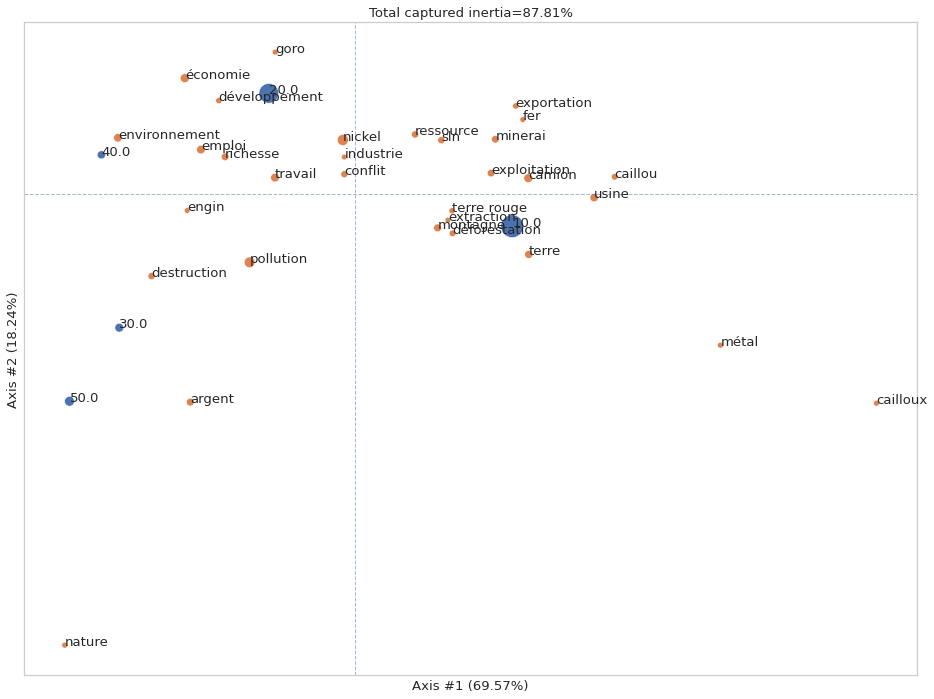

Commune de résidence.,Dumbéa,Hienghène,Mont-Dore,Nouméa,Païta,Yaté
Mot énoncé,,,,,,
argent,8,14,10,11,5,9
caillou,5,8,8,10,3,0
cailloux,0,19,0,0,0,0
camion,12,33,10,18,2,2
conflit,9,1,14,8,6,6
destruction,10,9,11,10,3,1
déforestation,3,6,11,13,3,0
développement,7,2,3,6,1,5
emploi,12,1,17,29,12,5


<Figure size 1152x864 with 1 Axes>

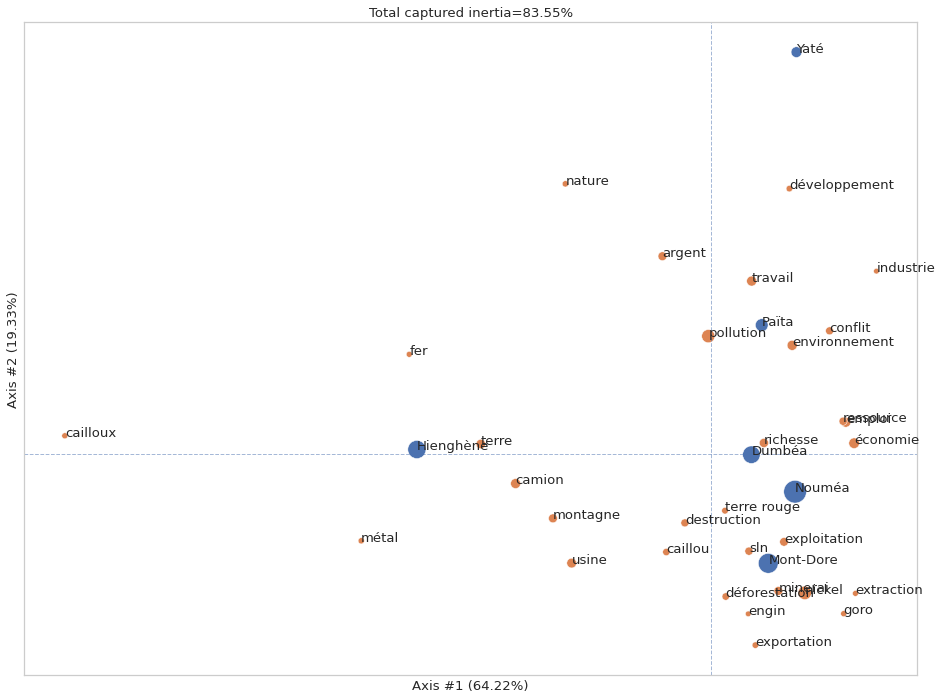

Distinction communes minières ; non-minière et mixte (Nouméa),Minière,Mixte,Non minière
Mot énoncé,,,
argent,29,13,31
caillou,10,10,19
cailloux,0,0,21
camion,22,21,61
conflit,21,9,20
destruction,21,11,28
déforestation,11,13,17
développement,10,8,12
emploi,29,31,37


<Figure size 1152x864 with 1 Axes>

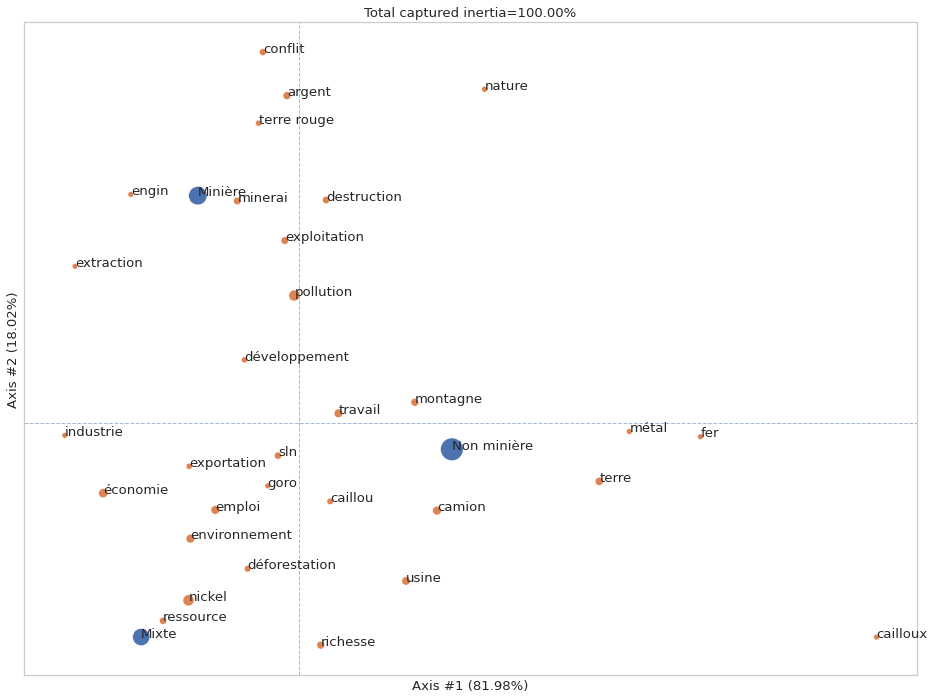

In [27]:
sns.set_theme(style="whitegrid", font_scale=1.10, rc={"figure.figsize": (16, 12)})
ca = CA(42)

for attribut in ["GAD", "Question 8.1", "Question 8.2"]:
    ref = gen_ca_dataset(attribut)
    display(ref.sort_index())
    ca.fit(ref)
    # ca.plot(coords=("principal", "standard"))
    # plt.show()
    # ca.plot(coords=("standard", "principal"))
    # plt.show()
    ca.plot(coords=("principal", "principal"), legend=None)
    plt.show()


## Répartition des nombres de citations

[
    ('nickel', 189),
    ('pollution', 183),
    ('économie', 112),
    ('camion', 104),
    ('travail', 100),
    ('environnement', 100),
    ('emploi', 97),
    ('usine', 89),
    ('terre', 83),
    ('montagne', 75)
]

<AxesSubplot:ylabel='Count'>

<Figure size 1152x864 with 1 Axes>

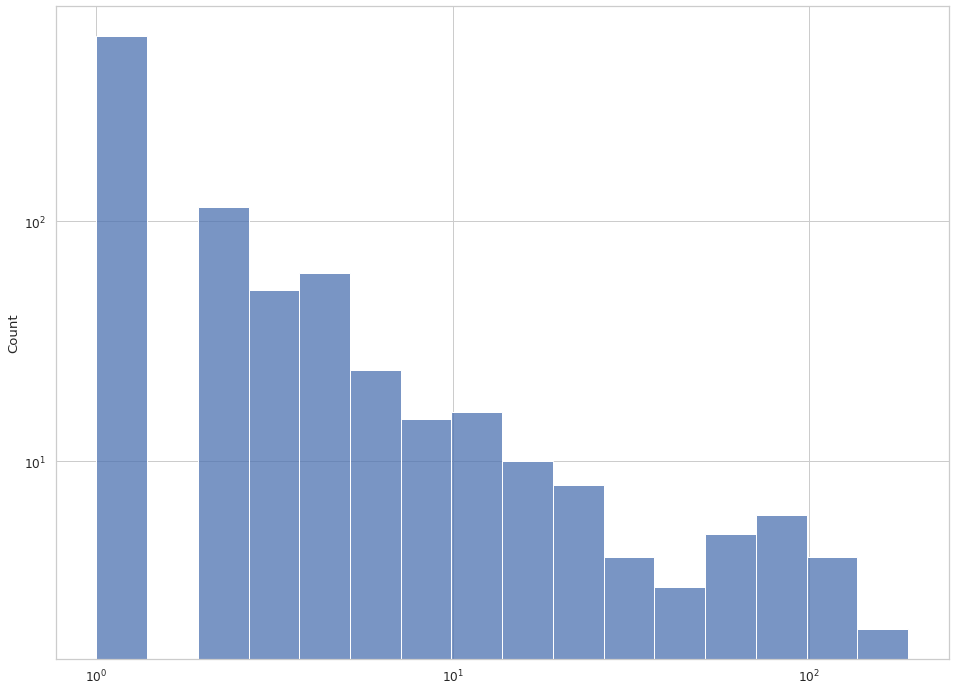

In [86]:
# dict_mine
display(all_words_mine.most_common(10))
sns.histplot(all_words_mine, bins = "doane", log_scale=(True,True))

/home/romulus/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,words,counts,log_words,log_counts
0,868.0,1.000000,6.766192,0.000000
1,22.0,11.444444,3.091042,2.437504
2,7.0,21.888889,1.945910,3.085979
3,2.0,32.333333,0.693147,3.476099
4,1.0,42.777778,0.000000,3.756019
5,3.0,53.222222,1.098612,3.974476
6,4.0,63.666667,1.386294,4.153661
7,2.0,74.111111,0.693147,4.305565
8,1.0,84.555556,0.000000,4.437409
9,4.0,95.000000,1.386294,4.553877


<AxesSubplot:xlabel='log_counts', ylabel='log_words'>

<Figure size 1152x864 with 1 Axes>

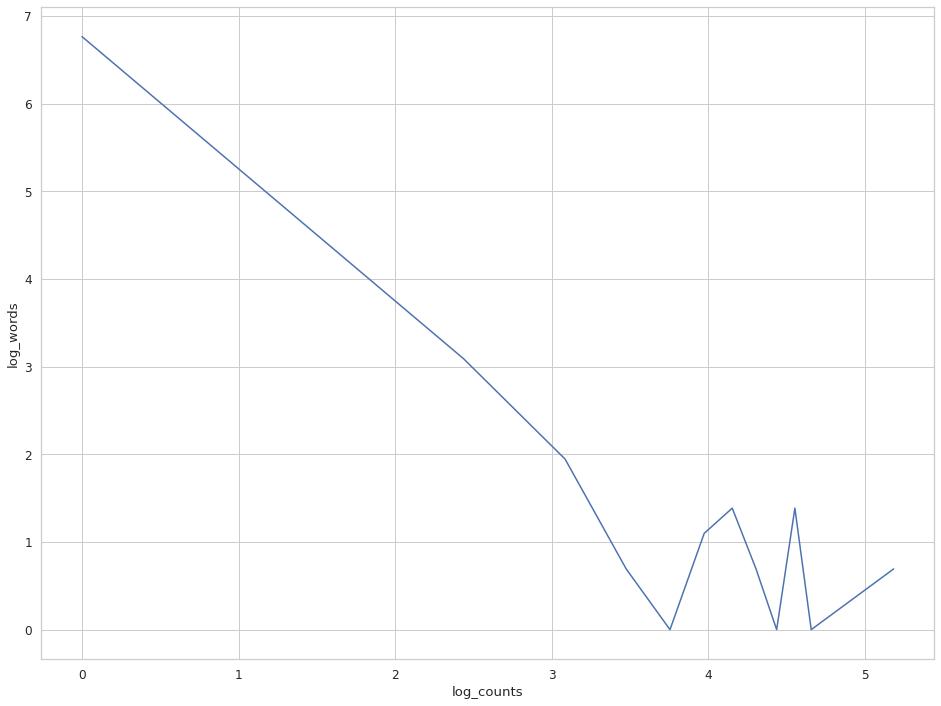

In [95]:
y, x = np.histogram(list(all_words_mine.values()), bins = "doane")
df_zipf = pd.DataFrame([y, x], index=["words", "counts"]).T.dropna()
df_zipf["log_words"] = np.log(df_zipf["words"])
df_zipf["log_counts"] = np.log(df_zipf["counts"])
display(df_zipf)
sns.lineplot(x = "log_counts", y ="log_words", data = df_zipf)


/home/romulus/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/tmp/ipykernel_433530/3005281738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["log_words_predict"] = (model.predict())
/tmp/ipykernel_433530/3005281738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["words_predict"] = np.exp(model.predict())


,words,counts,log_words,log_counts,log_words_predict,words_predict
0,868.0,1.000000,6.766192,0.000000,6.106788,448.894350
1,22.0,11.444444,3.091042,2.437504,3.032330,20.745509
2,7.0,21.888889,1.945910,3.085979,2.214400,9.155911
3,2.0,32.333333,0.693147,3.476099,1.722337,5.597592
4,1.0,42.777778,0.000000,3.756019,1.369270,3.932477
5,3.0,53.222222,1.098612,3.974476,1.093726,2.985378
6,4.0,63.666667,1.386294,4.153661,0.867718,2.381469
7,2.0,74.111111,0.693147,4.305565,0.676119,1.966231
8,1.0,84.555556,0.000000,4.437409,0.509823,1.664996
9,4.0,95.000000,1.386294,4.553877,0.362920,1.437521


<Figure size 1152x864 with 1 Axes>

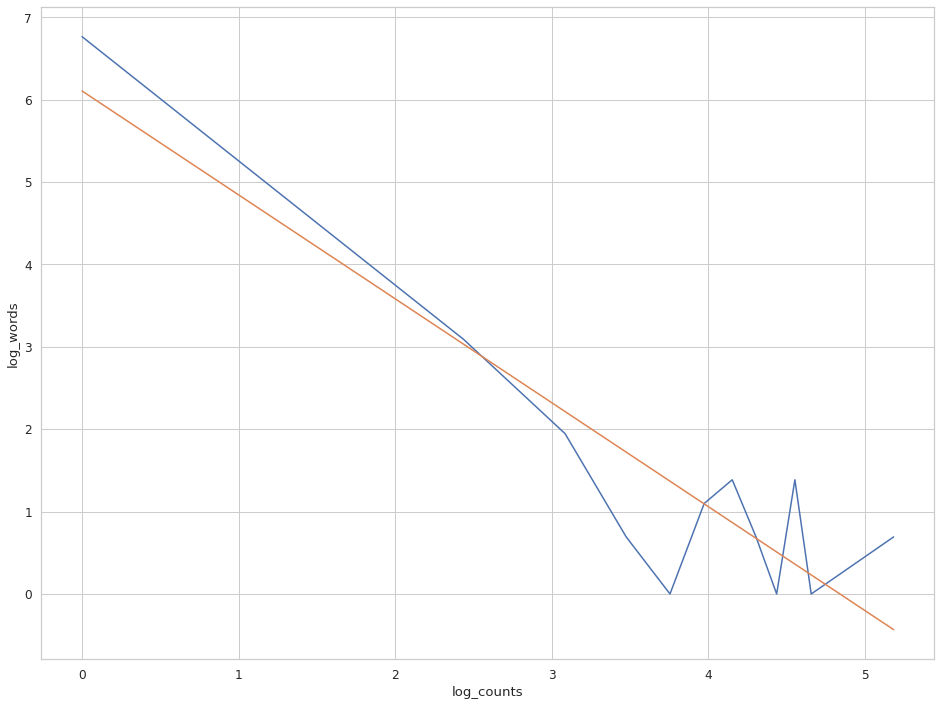

<Figure size 1152x864 with 1 Axes>

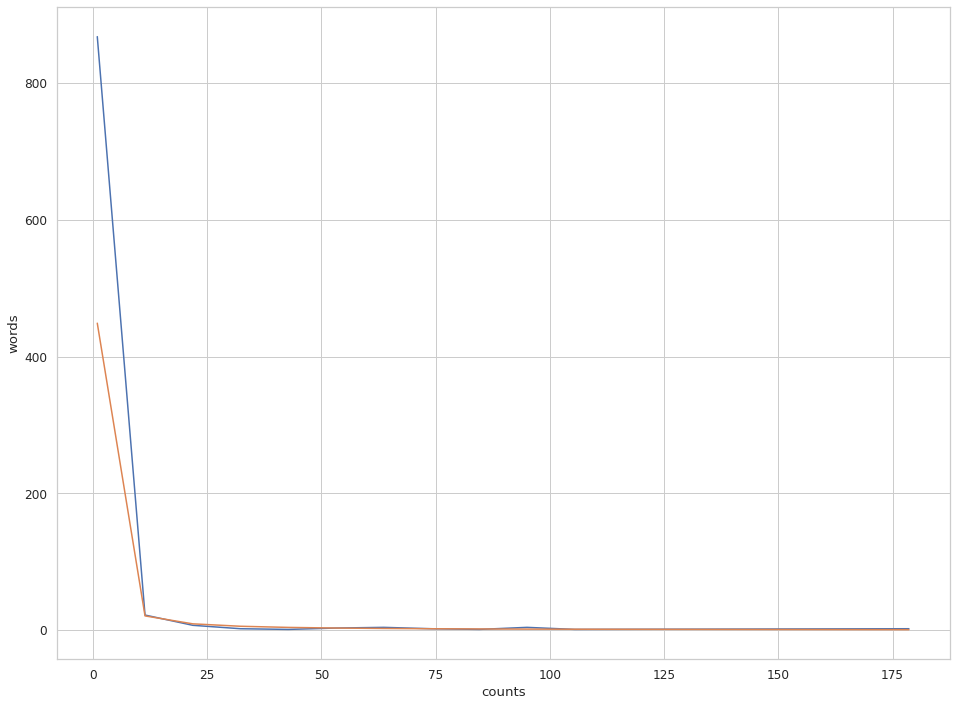

In [104]:
data = df_zipf[df_zipf["words"] != 0.0]
model = smf.ols("log_words ~ log_counts", data=data).fit()
model.summary()
data["log_words_predict"] = (model.predict())
data["words_predict"] = np.exp(model.predict())
display(data)
sns.lineplot(x = "log_counts", y ="log_words", data = data)
sns.lineplot(x = "log_counts", y ="log_words_predict", data = data)
plt.show()

sns.lineplot(x = "counts", y ="words", data = data)
sns.lineplot(x = "counts", y ="words_predict", data = data)
plt.show()



Calculating best minimal value for power law fit
1.9447114842466844
0.06519128587938339
(97.4090789116238, 4.04855023904722e-09)
(3.5788237609642417, 0.18655762976506907)


<Figure size 1152x864 with 1 Axes>

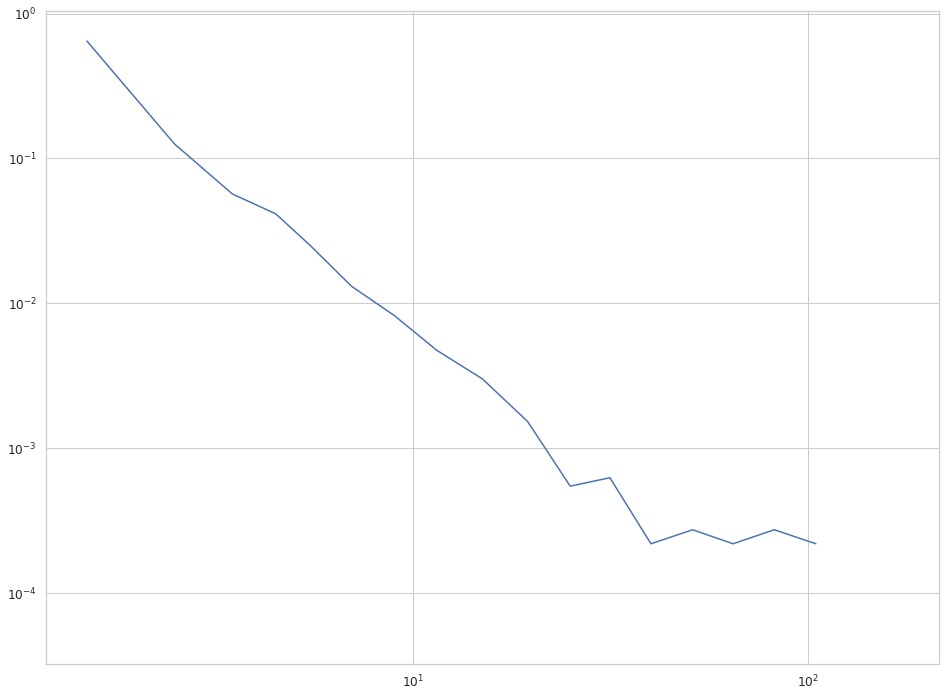

In [114]:
import powerlaw
powerlaw.plot_pdf(list(all_words_mine.values()))
fit = powerlaw.Fit(list(all_words_mine.values()), discrete=True)
print(fit.power_law.alpha)
print(fit.power_law.sigma)
print(fit.distribution_compare('power_law', 'exponential'))
print(fit.distribution_compare('power_law', 'lognormal_positive'))